# Stats pour les publications en anglais

Ce notebook reprend les mêmes choses que dans [`recouvrement`](recouvrement.ipynb) sauf qu'on traite les publications anglaises.

In [ ]:
from agrovoc import Agrovoc
from rdflib import Graph

lang = 'en'
g = Graph()
agrovoc = Agrovoc(g, lang=lang)

In [4]:
import importlib
import grobid_utils
importlib.reload(grobid_utils)
from grobid_utils import *

class GrobidCallback:
    def __init__(self, agrovoc, message=""):
        self.average_recall = 0
        self.average_precision = 0
        self.average_overlap = 0
        self.average_nb_entities = 0
        self.message = message
        self.examples = 0
        self.memory = []
        self.text = ""
        self.agrovoc = agrovoc

    def update(self, descripteurs, concepts):
        set2 = to_agrovoc(concepts, self.agrovoc)
        self.text += ' '.join([word.replace(' ', '_') for _, word in set2])
        overlap = len(set2) / len(concepts) if len(concepts) > 0 else 0
        res = intersection(descripteurs, set2)
        recall = len(res) / len(descripteurs) if len(descripteurs) > 0 else 0
        precision = len(res) / len(set2) if len(set2) > 0 else 0
        self.memory.append([recall, precision, overlap])
        self.average_recall = (self.average_recall * self.examples + recall) / (self.examples + 1)
        self.average_nb_entities = (self.average_nb_entities * self.examples + len(concepts)) / (self.examples + 1)
        self.average_precision = (self.average_precision * self.examples + precision) / (self.examples + 1)
        self.average_overlap = (self.average_overlap * self.examples + overlap) / (self.examples + 1)
        self.examples += 1
        return "{} : {} , {} , {}".format(self.message, recall, precision, overlap)

In [ ]:
file = pd.read_excel('2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx')
file = file.loc[file.LANGUE_DOC=="eng"]

cagro = GrobidCallback(agrovoc, "Agrovoc")

for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS_ANGLAIS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), descriptors.split(";")))
    else:
        print('Skipped ', i)
        continue
    metadata = to_agrovoc(descriptors, agrovoc)
    xml = pdf_to_xml(pdf)
    try:
        text_json = extract_entities(xml, lang=lang)
        ent_and_cat = fetch_entities(text_json)    
    except Exception as e:
        print('Failed to process ', i, pdf)
        print(e)
        continue
    print(cagro.update(metadata, ent_and_cat))
  
    if cagro.examples > 200:
        break
        
print(cagro.average_recall, cagro.average_precision, cagro.average_overlap, cagro.average_nb_entities)
print(len(cagro.memory))

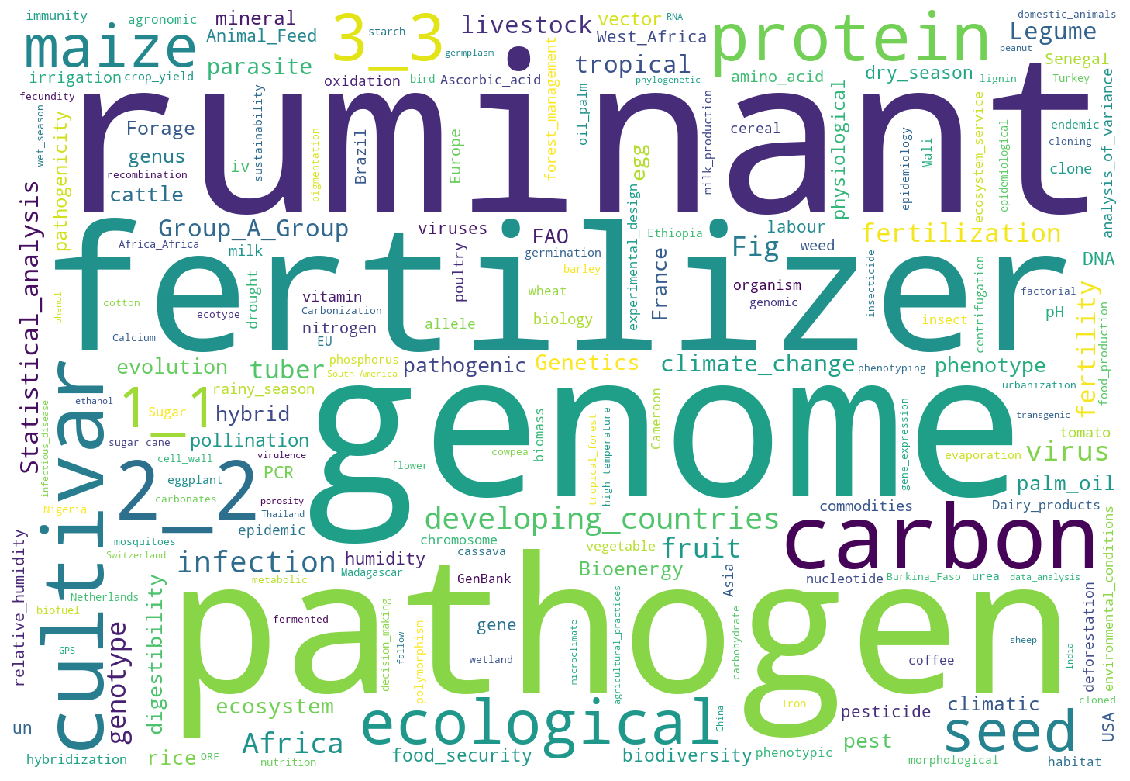

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 15))
img = WordCloud(width=1440, height=990, margin= 10, background_color='white').generate(cagro.text)
ax.imshow(img)
plt.axis('off')
plt.savefig('resources/wordclouden.png')

In [45]:
tips = pd.DataFrame(cagro.memory, columns=['Recall', 'Precision', 'Overlap'])
tips.to_csv('en_metrics.csv', index=False)

In [ ]:
abst_agro = GrobidCallback(agrovoc, "Agrovoc")

for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS_ANGLAIS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), descriptors.split(";")))
    else:
        print('Skipped ', i)
        continue
    metadata = to_agrovoc(descriptors, agrovoc)
    abstract = row['RESUM']
    try:
        text_json = extract_entities(abstract, mode='noxml')
        ent_and_cat = fetch_entities(text_json)    
    except Exception as e:
        print('Failed to process ', i, pdf)
        print(e)
        continue
    print(abst_agro.update(metadata, ent_and_cat))
  
    if abst_agro.examples > 300:
        break
        
print(abst_agro.average_recall, abst_agro.average_precision, abst_agro.average_overlap, abst_agro.average_nb_entities)

In [12]:
tips = pd.DataFrame(abst_agro.memory, columns=['Recall', 'Precision', 'Overlap'])
tips.to_csv('en_abstract_metrics.csv', index=False)